In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.metrics import accuracy_score, classification_report, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, ClassifierMixin
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint

# Standardize random state for reproducibility
import numpy as np
import random

np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

In [2]:
# Load dataset
df = pd.read_csv('../datasets/Titanic-Dataset.csv') # change path as needed

# Function to preprocess missing values
def preprocess_missing_values(df):
    df = df.copy()
    df['Age'].fillna(df['Age'].median(), inplace=True)
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
    return df

# Feature engineering function (added back Title extraction)
def feature_engineering(df):
    df = df.copy()
    # Create FamilySize: total family members including self
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

    # Create IsAlone: 1 if traveling alone, 0 otherwise
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

    # Extract Title from Name: e.g., Mr, Mrs, Miss, etc.
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')

    # Bin Age into categories: Child, Teen, Adult, Elder
    df['AgeBin'] = pd.cut(df['Age'], bins=[0, 12, 20, 40, 120], labels=['Child', 'Teen', 'Adult', 'Elder'])

    # Bin Fare into quartiles: Low, Mid, High, VeryHigh
    df['FareBin'] = pd.qcut(df['Fare'], 4, labels=['Low', 'Mid', 'High', 'VeryHigh'])
    
    return df

# Select initial features
initial_features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Name']

In [3]:
# Pipelines and Transformations


# Wrapper functions to handle array to dataframe conversion
def apply_missing_values_preprocessing(X):
    df = pd.DataFrame(X, columns=initial_features)
    df = preprocess_missing_values(df)
    return df

def apply_feature_engineering(X):
    df = pd.DataFrame(X, columns=initial_features)
    df = feature_engineering(df)
    return df

# Define full preprocessing pipeline using FunctionTransformer
numeric_features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize']
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = ['Sex', 'Embarked', 'Title', 'AgeBin', 'FareBin']  # Added back Title
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(sparse_output=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Complete pipeline with FunctionTransformers for preprocessing and feature engineering
full_pipeline = Pipeline(steps=[
    ('missing_values_preprocessing', FunctionTransformer(func=apply_missing_values_preprocessing, validate=False)),
    ('feature_engineering', FunctionTransformer(func=apply_feature_engineering, validate=False)),
    ('preprocessing', preprocessor)
])

# Fit and transform
X = full_pipeline.fit_transform(df[initial_features])
y = df['Survived'].values

# Split dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # Changed to float for BCE
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)  # Changed to float for BCE


# Create DataLoaders (generator set for reproducibility)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, generator=torch.Generator().manual_seed(42))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

/tmp/ipykernel_6767/1418116440.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
/tmp/ipykernel_6767/1418116440.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

In [4]:
# Pipelines and Transformations

# Wrapper functions to handle array to dataframe conversion
def apply_missing_values_preprocessing(X):
    df = pd.DataFrame(X, columns=initial_features)
    df = preprocess_missing_values(df)
    return df

def apply_feature_engineering(X):
    df = pd.DataFrame(X, columns=initial_features)
    df = feature_engineering(df)
    return df

# Define full preprocessing pipeline using FunctionTransformer
numeric_features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize']
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = ['Sex', 'Embarked', 'Title', 'AgeBin', 'FareBin']  # Added back Title
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(sparse_output=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Complete pipeline with FunctionTransformers for preprocessing and feature engineering
full_pipeline = Pipeline(steps=[
    ('missing_values_preprocessing', FunctionTransformer(func=apply_missing_values_preprocessing, validate=False)),
    ('feature_engineering', FunctionTransformer(func=apply_feature_engineering, validate=False)),
    ('preprocessing', preprocessor)
])

# Fit and transform
X = full_pipeline.fit_transform(df[initial_features])
y = df['Survived'].values

# Split dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # Changed to float for BCE
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)  # Changed to float for BCE


# Create DataLoaders (generator set for reproducibility)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, generator=torch.Generator().manual_seed(42))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

/tmp/ipykernel_6767/1418116440.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
/tmp/ipykernel_6767/1418116440.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

In [5]:
# Neural Network Model and Hyperparameter Tuning Class

# Define the neural network model (needed for the classifier)
class TitanicNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1):  # output_size=1 for binary
        super(TitanicNN, self).__init__() # we call the constructor of the parent class nn.Module
        self.fc1 = nn.Linear(input_size, hidden_size) # first fully connected layer
        self.relu = nn.ReLU() # activation function
        self.fc2 = nn.Linear(hidden_size, output_size) # second fully connected layer
        
    def forward(self, x):
        out = self.fc1(x) # pass input through first layer
        out = self.relu(out) # apply activation function
        out = self.fc2(out) # pass through second layer
        
        return out

# Custom PyTorch Estimator for sklearn compatibility
class PyTorchEstimator(BaseEstimator, ClassifierMixin):
    def __init__(self, hidden_size=16, learning_rate=0.001, epochs=100, optimizer_type='adam', criterion_type='bce_logits', random_state=42):
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.optimizer_type = optimizer_type
        self.criterion_type = criterion_type
        self.random_state = random_state
        self.model = None
    
    def _build_model(self, input_size):
        torch.manual_seed(self.random_state)
        model = TitanicNN(input_size, self.hidden_size, 1)
        return model
    
    def _get_criterion(self):
        if self.criterion_type == 'bce_logits':
            return nn.BCEWithLogitsLoss()
        elif self.criterion_type == 'bce':
            return nn.BCELoss()
        elif self.criterion_type == 'mse':
            return nn.MSELoss()
        else:
            return nn.BCEWithLogitsLoss()  # default
    
    def _get_optimizer(self, model):
        if self.optimizer_type == 'adam':
            return optim.Adam(model.parameters(), lr=self.learning_rate)
        elif self.optimizer_type == 'sgd':
            return optim.SGD(model.parameters(), lr=self.learning_rate)
        elif self.optimizer_type == 'rmsprop':
            return optim.RMSprop(model.parameters(), lr=self.learning_rate)
        else:
            return optim.Adam(model.parameters(), lr=self.learning_rate)  # default
    
    def fit(self, X, y):
        # Convert to tensors
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32)
        
        # Create DataLoader
        dataset = TensorDataset(X_tensor, y_tensor)
        loader = DataLoader(dataset, batch_size=32, shuffle=True, generator=torch.Generator().manual_seed(self.random_state))
        
        # Build and train model
        input_size = X.shape[1]
        self.model = self._build_model(input_size)
        criterion = self._get_criterion()
        optimizer = self._get_optimizer(self.model)
        
        self.model.train()
        for epoch in range(self.epochs):
            for inputs, labels in loader:
                optimizer.zero_grad()
                logits = self.model(inputs).squeeze()  # Get raw logits from model
                if self.criterion_type == 'bce':
                    logits = torch.sigmoid(logits)  # Convert to probabilities for BCELoss
                loss = criterion(logits, labels)
                loss.backward()
                optimizer.step()
        
        return self
    
    def predict(self, X):
        X_tensor = torch.tensor(X, dtype=torch.float32)
        self.model.eval()
        with torch.no_grad():
            logits = self.model(X_tensor).squeeze()  # Get raw logits
            if self.criterion_type == 'bce_logits':
                predictions = torch.sigmoid(logits) > 0.5  # Convert logits to probabilities to make predictions
            elif self.criterion_type == 'bce':
                predictions = logits > 0.5  # Already probabilities from training to convert to make predictions
            else:
                predictions = torch.sigmoid(logits) > 0.5  # Default
        return predictions.numpy().astype(int)
    
    def predict_proba(self, X):
        X_tensor = torch.tensor(X, dtype=torch.float32)
        self.model.eval()
        with torch.no_grad():
            logits = self.model(X_tensor).squeeze()  # Get raw logits
            if self.criterion_type == 'bce_logits':
                probabilities = torch.sigmoid(logits)  # Convert logits to probabilities
            elif self.criterion_type == 'bce':
                probabilities = logits  # Already probabilities from training
            else:
                probabilities = torch.sigmoid(logits)  # Default to sigmoid
        return probabilities.numpy()

In [12]:
# Hyperparameter Tuning Execution

# Define hyperparameter distributions for random search
param_distributions = {
    'hidden_size': randint(8, 64),  # Random integer between 8 and 64
    'learning_rate': uniform(0.0001, 0.01),  # Random float between 0.0001 and 0.0101
    'epochs': randint(50, 200),  # Random integer between 50 and 200
    'optimizer_type': ['adam', 'sgd', 'rmsprop'],  # Different optimizer types
    'criterion_type': ['bce_logits', 'bce']  # Different loss functions (excluding mse for classification)
}

# Create stratified k-fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create scorer
scorer = make_scorer(accuracy_score) # Using accuracy for classification

# Create estimator
estimator = PyTorchEstimator(random_state=42)

# Perform random search
print("Performing hyperparameter tuning with Random Search and Stratified K-Fold...")
random_search = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=param_distributions,
    n_iter=20,
    cv=skf,
    scoring=scorer,
    n_jobs=1,
    verbose=1,
    random_state=42
)

# Fit on training data
random_search.fit(X_train, y_train)

# Best parameters and score
print(f"Best parameters: {random_search.best_params_}")
print(f"Best cross-validation score: {random_search.best_score_:.4f}")

# Use best parameters for final model
best_params = random_search.best_params_

Performing hyperparameter tuning with Random Search and Stratified K-Fold...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'criterion_type': 'bce_logits', 'epochs': 64, 'hidden_size': 52, 'learning_rate': 0.0008455064367977082, 'optimizer_type': 'rmsprop'}
Best cross-validation score: 0.8398
Best parameters: {'criterion_type': 'bce_logits', 'epochs': 64, 'hidden_size': 52, 'learning_rate': 0.0008455064367977082, 'optimizer_type': 'rmsprop'}
Best cross-validation score: 0.8398


In [7]:
# Initialize final model with best hyperparameters
input_size = X_train.shape[1] # number of features
hidden_size = best_params['hidden_size']
output_size = 1 # binary classification (survived or not)

model = TitanicNN(input_size, hidden_size, output_size)
epochs = best_params['epochs']
learning_rate = best_params['learning_rate']

In [8]:
# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss() # Binary Cross Entropy with Logits Loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
# Train the model
loss_history = []

for epoch in range(epochs):

    model.train() # set model to training mode
    epoch_loss = 0.0

    for inputs, labels in train_loader: # iterate over batches inputs = X_batch, labels = y_batch
        optimizer.zero_grad() # zero the parameter gradients
        outputs = model(inputs).squeeze() # forward pass
        loss = criterion(outputs, labels) # compute loss
        loss.backward() # backward pass
        optimizer.step() # update weights
        epoch_loss += loss.item() * inputs.size(0) # accumulate loss

    avg_loss = epoch_loss / len(train_loader.dataset)
    loss_history.append(avg_loss)

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

In [13]:
# Evaluate the model
model.eval() # set model to evaluation mode
with torch.no_grad(): # disable gradient calculation
    test_outputs = model(X_test_tensor)
    test_predictions = torch.sigmoid(test_outputs) > 0.5  # Apply sigmoid to logits
    accuracy = accuracy_score(y_test, test_predictions.numpy())
    print(f'Test Accuracy: {accuracy:.4f}')
    print(classification_report(y_test, test_predictions.numpy()))

Test Accuracy: 0.8156
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       105
           1       0.80      0.74      0.77        74

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.81       179
weighted avg       0.81      0.82      0.81       179



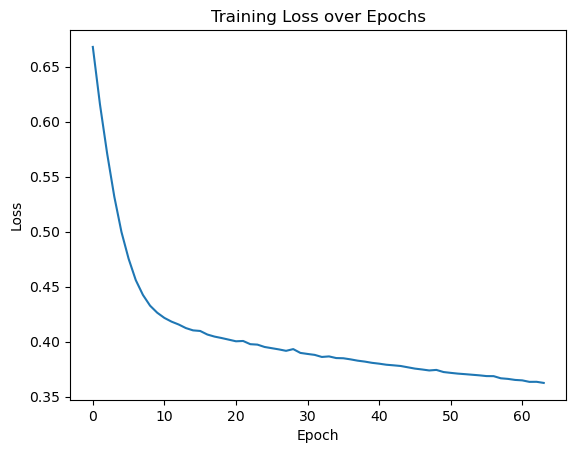

In [11]:
# Plot loss history
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()